# MNIST en Deep Learning

Dans ce TP, nous allons construire des algorithmes de Deep Learning pour tenter de reconnaître des chiffres manuscrits.

## Chargement des données et transformation

Nous allons travailler sur la base de données MNIST qui contient 60000 images en niveaux de grille de résolution 28x28, représentant les 10 chiffres de 0 à 9, ainsi qu'un jeu de test de 10000 images. Tout d'abord, chargeons ce jeu de données.

In [33]:
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchinfo import summary
from tqdm import tqdm

import matplotlib
import matplotlib.pyplot as plt
import scipy
import scipy.ndimage
import time
import numpy as np

train_dataset = datasets.MNIST('../data', train=True, download=True, transform=ToTensor())
#X_train_base, y_train_base = dataset_train.data.numpy(), dataset_train.target.numpy()

test_dataset = datasets.MNIST('../data', train=False, download=True, transform=ToTensor())
#X_test_base, y_test_base = dataset_test.data.numpy(), dataset_test.target.numpy()

Créer un dataloader et visualiser des images

BATCH INFO : input shape:  torch.Size([16, 1, 28, 28])  , labels shape:  torch.Size([16]) 



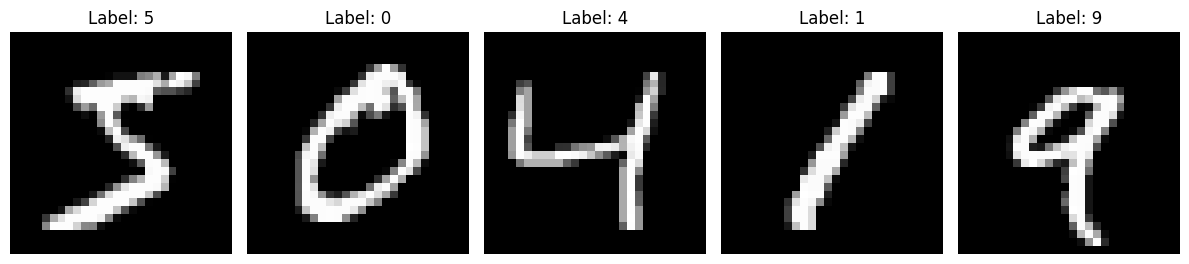

In [24]:
train_dataloader = DataLoader(train_dataset, batch_size=16)


# Parcourez un batch dans le DataLoader
for images, labels in train_dataloader:
    print("BATCH INFO : input shape: ", images.shape, " , labels shape: ", labels.shape, '\n')
    sample_images = images[:5]  # Les 5 premières images
    sample_labels = labels[:5]  # Les 5 premières étiquettes
    break  # On prend seulement le premier batch

# Affichez les images et leurs étiquettes
fig, axes = plt.subplots(1, 5, figsize=(12, 3))

for i, ax in enumerate(axes):
    ax.imshow(
        sample_images[i].squeeze(), cmap="gray"
    )  # .squeeze() pour retirer la dimension du canal
    ax.set_title(f"Label: {sample_labels[i].item()}")
    ax.axis("off")

plt.tight_layout()
plt.show()


## Construire un premier réseau de neurones

Construisons notre premier réseau de neurones.

Pour cela, nous allons créer un modèle Pytorch en utilisant la classe nn.Module vu précedemment:
* __model = Sequential()__

Puis utiliser les méthodes suivantes de Pytroch pour ajouter des couches à ce modèle :

* __nn.FLatten__ : on manipule des vecteurs et non des image, on passe de (28,28) -> (784,)
* __nn.Linear__ : on ajoute une couche dense (ou linéaire)
* __nn.Dropout__ : applique un dropout à la couche, pour éviter le surapprentissage
* __nn.ReLU__ : fonction d'activation relu au coeur du réseau
* __nn.Softmax__ : en sortie de réseau

In [99]:
nb_classes = 10
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(784, 12)  # Première couche dense avec 784 entrées et 12 sorties
        self.fc2 = nn.Linear(12, 12)   # Deuxième couche dense avec 12 entrées et 12 sorties
        self.fc3 = nn.Linear(12, nb_classes) # Troisième couche dense avec 12 entrées et nb_classes sorties
        self.dropout = nn.Dropout(0.5) # Couche de dropout
        self.relu = nn.ReLU()    # Fonction d'activation sigmoïde
        self.softmax = nn.Softmax(dim=1) # Fonction d'activation softmax

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x)) # Activation sigmoid pour la première couche
        x = self.relu(self.fc2(x)) # Activation sigmoid pour la deuxième couche
        x = self.dropout(x)           # Dropout
        x = self.softmax(self.fc3(x)) # Activation softmax pour la troisième couche
        return x

# Instanciation du modèle
model = MyModel()

# affichage du résumé du modèle
summary(model, input_size=(1,1,28,28))  # input_size= (batch_size, channels, dim_x, dim_y)

Layer (type:depth-idx)                   Output Shape              Param #
MyModel                                  [256, 10]                 --
├─Flatten: 1-1                           [256, 784]                --
├─Linear: 1-2                            [256, 12]                 9,420
├─ReLU: 1-3                              [256, 12]                 --
├─Linear: 1-4                            [256, 12]                 156
├─ReLU: 1-5                              [256, 12]                 --
├─Dropout: 1-6                           [256, 12]                 --
├─Linear: 1-7                            [256, 10]                 130
├─Softmax: 1-8                           [256, 10]                 --
Total params: 9,706
Trainable params: 9,706
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 2.48
Input size (MB): 0.80
Forward/backward pass size (MB): 0.07
Params size (MB): 0.04
Estimated Total Size (MB): 0.91

 On commence par créer une boucle d'entrainement qui va faciliter l'apprentissage de notre modèle sur nos données.

In [52]:
# Défintion de la boucle d'entrainement
def train_loop(
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    model: torch.nn.Module,
    loss_fn,
    optimizer,
    epoch: int,
)-> dict:
    start_time = time.time()

    # Apprentissage du modèle
    model.train()  # Met le modèle en mode entraînement
    train_loss, count = 0.0, 0
    for X, y in tqdm(train_dataloader, desc=f"Train epoch {epoch}"):
        # Prédiction du réseau de neurones
        y_hat = model(X)  
        # Calcul de l'erreur (y_hat, y)
        loss = loss_fn(y_hat, y)  
        # Backpropagation (MaJ des poids du réseau)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()
        count += X.shape[0]
    train_loss /= count

    # Test du modèle
    model.eval()
    with torch.no_grad():
        test_loss, count = 0.0, 0
        for X, y in tqdm(test_dataloader, desc=f"Test epoch {epoch}"):
            # Prédiction du réseau de neurones
            y_hat = model(X)  
            # Calcul de l'erreur (y_hat, y)
            loss = loss_fn(y_hat, y)  
            test_loss += loss.item()
            count += X.shape[0]
    test_loss /= count

    elapsed_time = time.time() - start_time
    print(
        f"Epoch {epoch} | Elapsed Time : {round(elapsed_time, 1)}s | Training Loss : {train_loss:.4f} | Test Loss : {test_loss:.4f}"
    )
    return model


On redéfinit également les données nécessaires à l'apprentissage et au test en créant un itérateur (ou __dataloader__)

In [53]:
batch_size = 256
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(train_dataset, batch_size=batch_size)

Ensuite, nous pouvons lancer l'apprentissage des paramètres.

In [54]:
epochs=2
loss_fn = nn.CrossEntropyLoss()
sgd_optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, nesterov=True)
for epoch in range(epochs):
    model = train_loop(train_dataloader, test_dataloader, model, loss_fn, sgd_optimizer, epoch)

Test epoch 0: 100%|███████████████████████████| 235/235 [00:05<00:00, 44.85it/s]


Epoch 0 | Elapsed Time : 23.6s | Training Loss : 0.0074 | Test Loss : 0.0065


Test epoch 1: 100%|███████████████████████████| 235/235 [00:04<00:00, 47.61it/s]

Epoch 1 | Elapsed Time : 10.4s | Training Loss : 0.0072 | Test Loss : 0.0064


Nous vous laissons analyser les résultats. Ce réseau de neurones est-il performant ?

__A vous de jouer__ : essayez de créer un meilleur réseau de neurones, afin d'atteindre le meilleur résultat possible.

In [ ]:
# Créer un meilleur réseau de neurones, et l'entraîner
# Objectif : avoir le meilleur résultat possible

# Nous ne donnons pas la correction. Il y a plusieurs réponses possibles.
# Vous pouvez par exemple ajouter des couches, modifier le nombre de neurones par couche et jouer sur le dropout.

Voyons ce que donne notre modèle sur un exemple.

In [ ]:
def plot_mnist_digit(image):
    """ Plot a single MNIST image."""
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(image, cmap = matplotlib.cm.binary)
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
    plt.show()
loss,acc = model.evaluate(X_test, y_test,  verbose=0)
index=800
print('The accuracy on the test set is ',(acc*100),'%')
plot_mnist_digit(X_test_base[index])
#cl=model.predict_classes(X_test[index].reshape((1,784)))
cl = np.argmax(model.predict(X_test[index].reshape((1,784))), axis=-1)

print("le chiffre reconnu est: ", cl[0])
print("le chiffre à reconnaitre  est: ", np.argmax(y_test[index]))

## CNN : réseaux de neurones convolutionnels

Nous allons maintenant implémenter un réseau de neurones convolutionnel.

Pour cet exercice, vous allez avoir besoin des méthodes Pytorch suivantes, en plus de celles déjà vues précédemment :

Construisons notre premier réseau de neurones.

* __nn.Conv2d__ : on ajoute une couche de convolution
* __nn.MaxPool2d__ : fonction de max pooling qui permet de réduire la dimension des images d'entrée

In [100]:
input_shape = (1, 1, 28, 28)
nb_classes = 10
# Définition du modèle
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=(3, 3))
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2))
        self.dropout1 = nn.Dropout2d(0.25)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(4 * 13 * 13 , 10)
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(10, nb_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.dropout1(x)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.dropout2(x)
        #x = self.fc2(x)
        return x
        
# Instanciation du modèle
model = MyModel()

# affichage du résumé du modèle
batch_size = 256
summary(model, input_size=(1,1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
MyModel                                  [1, 10]                   110
├─Conv2d: 1-1                            [1, 4, 26, 26]            40
├─ReLU: 1-2                              [1, 4, 26, 26]            --
├─MaxPool2d: 1-3                         [1, 4, 13, 13]            --
├─Dropout2d: 1-4                         [1, 4, 13, 13]            --
├─Flatten: 1-5                           [1, 676]                  --
├─Linear: 1-6                            [1, 10]                   6,770
├─ReLU: 1-7                              [1, 10]                   --
├─Dropout: 1-8                           [1, 10]                   --
Total params: 6,920
Trainable params: 6,920
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.03
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.03
Estimated Total Size (MB): 0.05

In [101]:
batch_size = 256
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(train_dataset, batch_size=batch_size)


In [102]:
epochs=20
loss_fn = nn.CrossEntropyLoss()
adam_optimizer = optim.Adam(model.parameters(), lr=0.001)
for epoch in range(epochs):
    model = train_loop(train_dataloader, test_dataloader, model, loss_fn, sgd_optimizer, epoch)

Test epoch 0: 100%|███████████████████████████| 235/235 [00:10<00:00, 21.67it/s]


Epoch 0 | Elapsed Time : 18.6s | Training Loss : 0.0091 | Test Loss : 0.0090


Test epoch 1: 100%|███████████████████████████| 235/235 [00:16<00:00, 14.35it/s]


Epoch 1 | Elapsed Time : 34.7s | Training Loss : 0.0091 | Test Loss : 0.0090


Test epoch 2: 100%|███████████████████████████| 235/235 [00:16<00:00, 13.87it/s]


Epoch 2 | Elapsed Time : 65.8s | Training Loss : 0.0091 | Test Loss : 0.0090


Test epoch 3: 100%|███████████████████████████| 235/235 [00:16<00:00, 14.36it/s]


Epoch 3 | Elapsed Time : 65.7s | Training Loss : 0.0091 | Test Loss : 0.0090


Test epoch 4: 100%|███████████████████████████| 235/235 [00:16<00:00, 14.30it/s]


Epoch 4 | Elapsed Time : 65.4s | Training Loss : 0.0091 | Test Loss : 0.0090


Test epoch 5: 100%|███████████████████████████| 235/235 [00:16<00:00, 14.30it/s]


Epoch 5 | Elapsed Time : 64.9s | Training Loss : 0.0091 | Test Loss : 0.0090


Test epoch 6: 100%|███████████████████████████| 235/235 [00:15<00:00, 15.48it/s]


Epoch 6 | Elapsed Time : 62.7s | Training Loss : 0.0091 | Test Loss : 0.0090


Test epoch 7: 100%|███████████████████████████| 235/235 [00:15<00:00, 15.53it/s]


Epoch 7 | Elapsed Time : 62.5s | Training Loss : 0.0091 | Test Loss : 0.0090


Test epoch 8: 100%|███████████████████████████| 235/235 [00:15<00:00, 14.82it/s]


Epoch 8 | Elapsed Time : 60.8s | Training Loss : 0.0091 | Test Loss : 0.0090


Test epoch 9: 100%|███████████████████████████| 235/235 [00:05<00:00, 40.67it/s]


Epoch 9 | Elapsed Time : 15.3s | Training Loss : 0.0091 | Test Loss : 0.0090


Test epoch 10: 100%|██████████████████████████| 235/235 [00:05<00:00, 42.15it/s]


Epoch 10 | Elapsed Time : 16.9s | Training Loss : 0.0091 | Test Loss : 0.0090


Test epoch 11: 100%|██████████████████████████| 235/235 [00:05<00:00, 39.49it/s]


Epoch 11 | Elapsed Time : 13.1s | Training Loss : 0.0091 | Test Loss : 0.0090


Test epoch 12: 100%|██████████████████████████| 235/235 [00:08<00:00, 27.96it/s]


Epoch 12 | Elapsed Time : 19.7s | Training Loss : 0.0091 | Test Loss : 0.0090


Test epoch 13: 100%|██████████████████████████| 235/235 [00:05<00:00, 43.74it/s]


Epoch 13 | Elapsed Time : 12.4s | Training Loss : 0.0091 | Test Loss : 0.0090


Test epoch 14: 100%|██████████████████████████| 235/235 [00:06<00:00, 35.96it/s]


Epoch 14 | Elapsed Time : 14.2s | Training Loss : 0.0091 | Test Loss : 0.0090


Test epoch 15: 100%|██████████████████████████| 235/235 [00:05<00:00, 41.12it/s]


Epoch 15 | Elapsed Time : 12.6s | Training Loss : 0.0091 | Test Loss : 0.0090


Test epoch 16: 100%|██████████████████████████| 235/235 [00:06<00:00, 38.51it/s]


Epoch 16 | Elapsed Time : 12.6s | Training Loss : 0.0091 | Test Loss : 0.0090


Test epoch 17: 100%|██████████████████████████| 235/235 [00:05<00:00, 43.61it/s]


Epoch 17 | Elapsed Time : 15.0s | Training Loss : 0.0091 | Test Loss : 0.0090


Test epoch 18: 100%|██████████████████████████| 235/235 [00:05<00:00, 41.32it/s]


Epoch 18 | Elapsed Time : 12.3s | Training Loss : 0.0091 | Test Loss : 0.0090


Test epoch 19: 100%|██████████████████████████| 235/235 [00:13<00:00, 16.90it/s]

Epoch 19 | Elapsed Time : 23.5s | Training Loss : 0.0091 | Test Loss : 0.0090


In [ ]:
def plot_mnist_digit(image):
    """ Plot a single MNIST image."""
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(image, cmap = matplotlib.cm.binary)
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
    plt.show()
#loss,acc = model.evaluate(x_test, y_test,  verbose=0)
#index=800
#print('The accuracy on the test set is ',(acc*100),'%')
#plot_mnist_digit(X_test_base[index])
#cl=model.predict_classes(x_test[index].reshape((1,28,28,1)))
#cl = np.argmax(model.predict(X_test[index].reshape((1,28,28,1))), axis=-1)


print("le chiffre reconnu est: ", cl[0])
print("le chiffre à reconnaitre  est: ", np.argmax(y_test[index]))


In [ ]:
# Créer un meilleur réseau de neurones convolutionnel, et l'entraîner
# Objectif : avoir le meilleur résultat possible

# Nous ne donnons pas la correction. Il y a plusieurs réponses possibles.
# Vous pouvez par exemple ajouter des couches convolutionnelles et max_pooling,
# modifier le nombre de convolutions ou leur taille et jouer sur le dropout.

## Bonus : Auto encodeur

L'auto-encodeur est un réseau de neurones qui compresse puis décompresse l'information. On l'entraîne en lui demandant de retrouver en sortie la même image que celle qu'il avait en entrée. Ici, l'information en entrée est en dimension 784 (28x28), et l'auto-encodeur va la compresser en dimension 2.

In [ ]:
encoding_dim = 2

model = Sequential()
model.add(Dense(encoding_dim, input_shape=(784,),activation='relu'))

model.add(Dense(784, activation='sigmoid'))

# Définition du modèle
class MyAutoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        slef.flatten()
        # Couche d'encodage
        self.encoder = nn.Linear(input_shape, encoding_dim)
        self.relu = nn.ReLU()

        # Couche de décodage
        self.decoder = nn.Linear(encoding_dim, 784)
        self.sigmoid = nn.Sigmoid()
        

    def forward(self, x):
        # Encodage
        x = self.relu(self.encoder(x))

        # Décodage
        x = self.sigmoid(self.decoder(x))

        return x

model= MyAutoencoder()

model.summary()



In [ ]:
decoded_imgs = model.predict(X_test)

Affichons quelques images pour voir comment se comporte notre auto-encodeur.

In [ ]:
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

__A vous de jouer__ : essayez d'améliorer l'auto-encodeur.

In [ ]:
## A COMPLETER

# Nous ne donnons pas la correction. Il y a plusieurs réponses possibles.
# Vous pouvez par exemple ajouter des couches ou modifier le nombre de neurones de la couche cachée.